In [63]:
# not run
# script for generating decoys

import subprocess
import os
import shutil

t=0
my_list = [i.split('_')[0] for i in os.listdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/input_pdbs')]
proteins = set(my_list)

for i in proteins:
    t+=1
    print(f'{t} from 176')
    print(i)
    os.mkdir(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')

    shutil.copy(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/create_lig', f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    shutil.copy(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/create.pl', f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')

    shutil.copy(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/input_pdbs/{i+"_l_u.pdb.ms"}', f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    shutil.copy(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/input_pdbs/{i+"_r_u.pdb.ms"}', f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    out_name = i+'.zd3.0.2.cg.out'
    shutil.copy(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/results/{out_name}', f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    os.chdir(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    subprocess.run(['./create.pl', f'{out_name}', '100'])
    os.chdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/')

In [2]:
import os, sys
import numpy as np
import pandas as pd
import itertools

from scipy.spatial import distance_matrix

from tqdm import tqdm_notebook as tqdm

### Modified parser for decoys
- extra column
- no HETATM labels (but some proteins are binded with GDP)
- returns dict with metainfo about atoms

In [556]:
class Parser:
    
    def __init__(self):
        
        # define thresholds for the binding site: 
        # minimum number of atoms in a ligand,
        # minimum number of protein atoms in the interface,
        # interface cutoff in Angstroms (interface_cutoff)
        self.min_atoms_in_ligand = 14
        self.min_atoms_in_interface = 10
        self.interface_cutoff = 10.0
        
        self.filter_list = ["12P", "15P", "1PE", "2CV", "2PE", "78M", "78N", "BCR", "BNG", "BOG",
        "BTB", "C14", "C8E", "CDL", "CLR", "CM5", "CPS", "DAO", "DGA", "DGD",
        "DMU", "DXC", "L2P", "LDA", "LFA", "LHG", "LI1", "LMG", "LMT", "LMU",
        "MPG", "MQ7", "MTN", "MYR", "MYS", "NS5", "OLA", "OLB", "OLC", "P4C",
        "P6G", "PC1", "PCW", "PE4", "PE5", "PE8", "PEE", "PG6", "PGV", "PL9",
        "PLC", "OLM", "PTY", "PX4", "SPN", "SPO", "SQD", "STE", "TGL", "U10", 
        "Y01", "HOH", 
        "CSD", "HYP", "BMT", "5HP", "ABA", "AIB", "CSW", "OCS", "DAL", "DAR",
        "DSG", "DSP", "DCY", "CRO", "DGL", "DGN", "DHI", "DIL", "DIV", "DLE",
        "DLY", "DPN", "DPR", "DSN", "DTH", "DTR", "DTY", "DVA", "CGU", "KCX",
        "LLP", "CXM", "FME", "MLE", "MVA", "NLE", "PTR", "ORN", "SEP", "TPO",
        "PCA", "PVL", "SAR", "CEA", "CSO", "CSS", "CSX", "CME", "TYS", "TPQ",
        "STY",
        "NH2", "CBX", "ACE", "FOR", "IVA", "BOC",
        "LYR", "MSE",
        "ADP", "AMP", "ATP", "CMP", "COA", "FAD", "FMN", "NAP", "NDP",
        "BGC", "GLC", "MAN", "BMA", "FUC", "GAL", "GLA", "NAG", "NGA", "SIA","XYS",
        "UNL"    
                           ]
    
    
    @staticmethod
    def parse_pdb_line(line):
        return {
            "record": line[:6],
            "serial": int(line[6:11]),
            "atom_name": line[12:16].strip(),
            "altloc": line[16].strip(),
            "resname": line[17:20].strip(),
            "chainid": line[21],
            "resseq": int(line[22:26]),
            "x": float(line[30:38]),
            "y": float(line[38:46]),
            "z": float(line[46:54]),
        }

    @staticmethod
    def read_pdb(filename):
        
        protein = [] # np.array(n_atoms, 3)
        ligands = {} # np.array(None, 3)
        protein_atoms = {}
        
        modres_list = []
        amino_list = ['CYS', 'ASP', 'SER', 'GLN', 'LYS','ILE', 'PRO', 'THR', 
                      'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG', 'TRP', 
                      'ALA', 'VAL', 'GLU', 'TYR', 'MET']
        
        with open(filename, "r") as file:
            for line in file:
                if line[:6] == "MODRES":
                    resn = line[12:16].strip()
                    chain = line[16]
                    resid = int(line[17:22])
                    modres_list.append("{:s}_{:s}_{:d}".format(resn, chain, resid))
                elif line[:6] in ["ATOM  ", "HETATM"]:
                    parsed = Parser.parse_pdb_line(line)
                    if parsed["altloc"] not in ["", "A"]:
                        continue
                    if parsed["resname"] in amino_list:
                        coords = [parsed["x"], parsed["y"], parsed["z"]]
                        protein_atoms[tuple(coords)] = []
                        protein_atoms[tuple(coords)].extend([parsed['atom_name'], parsed['resname']])
                        protein.append(coords)
                    else:
                        name = "{:s}_{:s}_{:d}".format(parsed["resname"], parsed["chainid"], parsed["resseq"])
                        if name not in modres_list:
                            if name not in ligands:
                                ligands[name] = []
                            ligands[name].append([parsed["x"], parsed["y"], parsed["z"]])
            
        protein = np.array(protein)
        
        ligands = {name : np.array(coords) for name, coords in ligands.items()}
        
        return protein, protein_atoms, ligands
    
    @staticmethod
    def get_interface(protein, ligand, interface_cutoff):
        
        matrix = distance_matrix(protein, ligand)
        protein_dist = np.min(matrix, axis=1)
        return np.count_nonzero(protein_dist <= interface_cutoff)

## The example below just illustrates the code work
## native unbound structures were not inluded into dataset

In [128]:
parser = Parser()
receptor, r_atoms, _ = parser.read_pdb('./experiment/1A2K/1A2K_r_u.pdb.ms')
ligand, l_atoms, _ = parser.read_pdb('./experiment/1A2K/1A2K_l_u.pdb.ms')

In [138]:
receptor_filt = []
for i,j in zip(r_atoms.values(), receptor):
    if i[1] != 'GLY':
        if i[0]== 'CB':
            receptor_filt.append(j)
    else:
        if i[0]== 'CA':
            receptor_filt.append(j)

In [140]:
ligand_filt = []
for i,j in zip(l_atoms.values(), ligand):
    if i[1] != 'GLY':
        if i[0]== 'CB':
            ligand_filt.append(j)
    else:
        if i[0]== 'CA':
            ligand_filt.append(j)

In [167]:
parser.get_interface(receptor_filt, ligand_filt, 10)

34

In [ ]:
matrix = distance_matrix(receptor_filt, ligand_filt)

In [185]:
rec_am_list = []
for i in receptor_filt:
    rec_am_list.append(r_atoms[tuple(i)][1])

In [188]:
lig_am_list = []
for i in ligand_filt:
    lig_am_list.append(l_atoms[tuple(i)][1])

In [191]:
df = pd.DataFrame(matrix, index=rec_am_list, columns = lig_am_list)
df

,GLU,PRO,GLN,VAL,GLN,PHE,LYS,LEU,VAL,LEU,...,GLU,HIS,ASP,LEU,GLU,VAL,ALA,GLN,THR,THR
GLY,56.152067,50.721131,50.036499,48.226428,44.950489,41.437610,37.606022,38.812442,33.427897,37.052229,...,50.751978,51.350673,46.162941,45.078285,48.850377,47.223423,42.234311,42.587079,47.226188,46.481612
ASP,51.733641,46.285164,45.695049,43.925644,40.643280,37.243345,33.381385,34.845851,29.529620,33.480407,...,48.207302,49.183502,44.111150,42.610002,46.474545,45.279214,40.165630,40.139390,44.956660,44.650936
LYS,50.799488,45.225537,44.572578,43.427648,39.615444,36.774260,32.346193,34.295958,28.718563,32.737821,...,49.727380,51.096730,45.991759,44.410035,48.617905,47.678577,42.496642,42.473459,47.573188,47.514872
PRO,54.445082,48.908274,47.804613,46.935762,42.812068,39.984716,35.343678,36.868876,31.035880,34.353861,...,51.222618,52.384065,47.071749,46.052518,50.473419,49.135875,44.059905,44.643351,49.794019,49.335244
ILE,57.305540,51.665758,50.963211,50.307003,46.120786,43.670845,38.888005,40.972803,35.204269,38.875735,...,56.349820,57.563816,52.291353,51.129784,55.470769,54.209278,49.105819,49.495217,54.592623,54.203791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARG,43.204355,38.121956,35.704297,36.623005,31.306522,29.967596,24.564689,26.005184,20.491565,22.253859,...,44.414395,47.079351,42.302818,40.921413,46.190601,46.147252,41.371621,41.836511,47.544834,48.232471
LEU,40.295686,35.559247,32.542515,33.553816,28.268229,26.911824,21.822559,22.469962,17.392506,18.041276,...,40.388268,43.318132,38.776522,37.403211,42.762159,42.987474,38.444748,38.959422,44.639688,45.533261
ALA,39.146904,34.395114,31.674023,33.556010,27.895190,27.675378,22.267086,24.017959,19.474959,20.617418,...,44.296973,47.602144,43.317054,41.584298,46.887074,47.529716,43.007904,43.130670,48.810301,50.072505
LEU,34.580866,29.624682,27.096302,28.531898,22.971148,22.458914,16.917357,19.083950,14.407308,16.541568,...,40.854293,44.320869,40.168637,37.917911,43.071337,44.036786,39.398938,39.024834,44.698428,46.284324


In [202]:
list(df.min(axis=1))

[21.268146463667208,
 17.18222075285962,
 17.32520478955443,
 20.78198296602131,
 24.719989279932943,
 21.865432170437423,
 17.89263831859349,
 20.965335151148906,
 23.25265692345716,
 19.665062750980482,
 16.12336943693842,
 20.491810290943064,
 21.716709603436705,
 17.03751287600394,
 17.465920702900263,
 22.511628239645397,
 21.832371927942233,
 18.438119155705664,
 21.394824467613656,
 25.308554640674362,
 21.857537784480666,
 21.105346171053434,
 25.572738648803345,
 29.386724689900372,
 25.828968949611596,
 31.66059244549918,
 30.54321675920858,
 27.582677136202715,
 31.891090965973557,
 31.476121648004856,
 27.58731753904319,
 30.686734902885966,
 34.07592414007285,
 37.88366624285458,
 35.40057837098146,
 30.892090670590747,
 29.527602442460513,
 26.174019676006967,
 23.797726719163748,
 22.496210036359457,
 19.78084886955057,
 22.26439689279725,
 25.519172126070234,
 28.266416221374794,
 29.113783900413907,
 33.512618295203374,
 34.08919553172236,
 34.43934630622365,
 36.32934

In [205]:
stat = pd.DataFrame({'a1':rec_am_list, 'a2':list(df.idxmin(axis=1)), 'dist':list(df.min(axis=1))},
                   columns=['a1', 'a2', 'dist'])
stat = stat[stat.dist<=10]
stat

,a1,a2,dist
67,THR,ARG,6.709933
68,ALA,ARG,7.046614
84,VAL,ARG,9.506184
86,GLN,THR,8.627986
94,ILE,THR,9.230253
96,GLY,THR,7.971699
120,ALA,THR,8.900443
122,HIS,ALA,9.648693
123,ASN,ALA,8.928176
162,TRP,GLY,6.689701


In [269]:
hydro_dict = {'h-phob': ['GLY', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'PHE', 'MET','TRP'], 
              'h-phil': ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'LYS', 'SER', 'THR', 'TYR']}

In [270]:
add_list = []
for index, row in stat.iterrows():
    a = 'h-phob' if row.a1 in hydro_dict['h-phob'] else 'h-phil'
    b = 'h-phob' if row.a2 in hydro_dict['h-phob'] else 'h-phil'     
    my_list = sorted([a, b])
    add_list.append(str(my_list[0]+ '+' + my_list[1]))

In [272]:
stat['h-type'] = add_list

In [273]:
stat_dict = {}
for i in set(stat['h-type'].to_list()):
    stat_dict[i] = stat[stat['h-type']== i].dist.to_list()

In [274]:
stat_dict

{'h-phil+h-phil': [6.709932562999424,
  8.6279861497339,
  9.99494802387687,
  8.8197311183505],
 'h-phil+h-phob': [7.046614293403601,
  9.5061840924737,
  9.230252975948167,
  7.971698627017959,
  8.900442517088687,
  9.64869302030073,
  8.928175849522681,
  3.404451497671835,
  7.090821743634506,
  9.840976425131807,
  5.786617060079232,
  4.584434316248841,
  6.097525809703482,
  8.914844305987629,
  8.767497134302358,
  6.8028562383751785,
  4.986701013696332,
  5.97426288340244,
  8.63951700038839,
  8.059608117024052,
  9.002976007965373,
  4.853452070433992,
  7.166938397949296,
  5.115926015884127,
  2.7924079214899873],
 'h-phob+h-phob': [6.689700890174389,
  7.6987762014491645,
  5.133548967332447,
  8.92847741779079,
  8.593238330222198]}

In [276]:
h_list= sorted(['h-phob', 'h-phil'])

In [277]:
am_gr_list = []
for m in list(itertools.combinations(h_list, 2)):
    am_gr_list.append(m[0]+'+'+m[1])
for i in h_list:
    if str(i+'+'+i) not in am_gr_list:
        am_gr_list.append(i+'+'+i)

In [386]:
am_gr_list

['h-phil+h-phob', 'h-phil+h-phil', 'h-phob+h-phob']

In [283]:
h_counts = {}
zero_vector = np.array([0]*20)
for i in am_gr_list:
    try:
        counts, bins = np.histogram(stat_dict[i], bins=20)
        h_counts[i] = counts
    except:
        h_counts[i] = zero_vector

In [284]:
h_counts

{'h-phil+h-phob': array([1, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 1, 3, 0, 2, 0, 2, 4, 1, 3]),
 'h-phil+h-phil': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]),
 'h-phob+h-phob': array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])}

In [379]:
data = pd.DataFrame(h_counts, columns=am_gr_list, index=range(0,20))

In [380]:
data

,h-phil+h-phob,h-phil+h-phil,h-phob+h-phob
0,1,1,1
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,2,0,0
6,2,0,0
7,0,0,0
8,1,0,1
9,2,0,0


In [289]:
label = 1

In [382]:
df_new = pd.DataFrame(columns=['matrix', 'label'])
df_new.loc[0, 'matrix'] = data.to_numpy()
df_new.loc[0, 'label'] = label
df_new

,matrix,label
0,"[[1, 1, 1], [1, 0, 0], [0, 0, 0], [0, 0, 0], [...",1


In [385]:
#os.mkdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/features')
df_new.to_csv('/home/nastya/decoys_bm4_zd3.0.2_15deg/features/1A2K_0.csv', index=False)

## Decoy files splitting (into r and l)

In [295]:
import glob

In [436]:
dir_list = os.listdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/')

In [437]:
len(dir_list)

176

In [439]:
for i in dir_list:
    os.chdir(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{i}')
    files = glob.glob('./complex*')
    for file in files:
        with open(file, 'r') as inp:
            a = inp.readline()
            while not a.startswith('ATOM'): # some files are strangely corrupted
                a = inp.readline()
            print(a)
            name = file.split('/')[1].split('.')[1]
            with open('complex.r.'+name+'.pdb', 'w') as out:
                out.write(f'{a}\n')
                for line in inp:
                    if int(line[6:11].strip()) != 1:
                        out.write(f'{line}\n')
                    else:
                        break
            with open('complex.l.'+name+'.pdb', 'w') as out2:
                out2.write(f'{line}\n')
                new_lines = inp.readlines()
                for new_line in new_lines:
                    out2.write(f'{new_line}\n')
    os.chdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/')

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63         -0.15

ATOM      1  N   GLY A   5      29.608  48.744  98.707  5     1 1.63        

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63         -0.15

ATOM      1  N   ARG N   2      38.891  40.104  71.632  4     1 1.63        

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63         -0.15

ATOM      1  N   ASP A   7      11.511  15.322   7.127  8     1 1.63        

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63         -0.15

ATOM      1  N   SER A   4     -10.772  51.729  15.098  2     1 1.63        

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63         -0.15

ATOM   6947  N   GLU F  23     -45.903  55.386  37.875  8     1 1.63        

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   VAL    34      -7.468  33.044 -23.384 12     1 1.63    1GIA -0.15

ATOM      1  N   ALA A   1       6.920  20.381  -1.632 12     1 1.63         -0.15

ATOM      1  N   ALA A   1       6.920  20.381  -1.632 12     1 1.63         -0.15

ATOM      1  N   ALA A   1       6.920  20.381  -1.632 12     1 1.63         -0.15

ATOM      1  N   ALA A   1       6.920  20.381  -1.632 12     1 1.63         -0.15

ATOM      1  N   ALA A   1       6.920  20.381  -1.632 12     1 1.63        

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63         -0.15

ATOM      1  N   GLN A 566      69.285  35.620  10.091  2     1 1.63        

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA -0.15

ATOM   1812  N   ILE X  16      28.957  24.214 -10.281 12     0 1.63    2PKA

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      -5.449  16.975  46.807  4     1 1.63        

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63         -0.15

ATOM   1658  N   GLU L   1      43.048  12.419  11.288  8     1 1.63        

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63         -0.15

ATOM      1  N   LYS O   3      44.674  64.103  24.463  4     1 1.63        

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM      1  N   ILE     1      -3.875  36.578  46.940 12     1 1.63    4PEP -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63        

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM   2539  N   MET D   1      30.069  26.308  -3.243  3     1 1.63         -0.15

ATOM      1  N   ASP A   1      49.537  19.166  71.363  8     1 1.63    1MLB -0.15

ATOM      1  N   ASP A   1      49.537  19.166  71.363  8     1 1.63    1MLB -0.15

ATOM      1  N   ASP A   1      49.537  19.166  71.363  8     1 1.63    1MLB -0.15

ATOM      1  N   ASP A   1      49.537  19.166  71.363  8     1 1.63    1MLB -0.15

ATOM      1  N   ASP A   1      49.537  19.166  71.363  8     1 1.63    1MLB

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63         -0.15

ATOM      1  N   CYS 1   1      13.745  43.318   4.682  5     1 1.63        

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR -0.15

ATOM   3158  N   GLY D   1      27.071  22.736  49.170  5     1 1.63    2CLR

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63         -0.15

ATOM      1  N   HIS A  12       9.979  56.618 -13.712  4     1 1.63        

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   GLY     1A      2.959  -4.247  61.220  5     1 1.63         -0.15

ATOM      1  N   ASP A   1      32.405  44.833  38.057  8     1 1.63         -0.15

ATOM      1  N   ASP A   1      32.405  44.833  38.057  8     1 1.63        

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63         -0.15

ATOM      1  N   ASN A 249      -3.478  31.874  63.754  2     1 1.63        

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      25.503   1.260  58.635  5     1 1.63        

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63         -0.15

ATOM      1  N   ARG A 439      22.242 -51.794 -64.401  4     1 1.63        

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      52.702 -33.137  -8.812  8     1 1.63        

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63         -0.15

ATOM      1  N   THR A   6      11.468  68.907 153.152  2     1 1.63        

ATOM      1  N   MET A   1      89.147  61.321  36.102  3     1 1.63         -0.15

ATOM      1  N   MET A   1      89.147  61.321  36.102  3     1 1.63         -0.15

ATOM      1  N   MET A   1      89.147  61.321  36.102  3     1 1.63         -0.15

ATOM      1  N   MET A   1      89.147  61.321  36.102  3     1 1.63         -0.15

ATOM      1  N   MET A   1      89.147  61.321  36.102  3     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63        

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      34.278  18.569  35.753  8     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63         -0.15

ATOM      1  N   GLY A   2      12.457  40.161 -16.750  5     1 1.63        

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN -0.15

ATOM      1  N   ASP L   1     300.421  12.558  71.815  8     1 1.63    1NSN

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      40.542  13.416  -3.882  3     1 1.63        

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63         -0.25

ATOM      1  N   PRO A  31      62.108  54.441  -1.736  3     1 1.63        

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA -0.15

ATOM   1801  N   CYS B   1      11.226  21.179  11.827  5     1 1.63    2CGA

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63         -0.15

ATOM      1  N   VAL A  54      -0.333   5.514 -36.842 12     1 1.63        

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63         -0.15

ATOM      1  N   HIS A  26       2.120   9.503  69.116  4     1 1.63        

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03          0.10

ATOM      1  CA  HIS A   3      24.803 -19.953  -0.705  3     1 2.03        

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63         -0.15

ATOM      1  N   ILE A  36      10.416  30.176   9.959 12     1 1.63        

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63         -0.15

ATOM      1  N   HIS A   1A    -10.786  48.903  75.414  4     1 1.63        

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63         -0.15

ATOM      1  N   GLY A 116      68.330  16.941  -7.060  5     1 1.63        

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG -0.15

ATOM      1  N   GLN L   1      37.957  48.313-116.251  2     1 1.63    1GIG

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63         -0.15

ATOM   2323  N   GLN H   3      55.834 -28.434  16.243  2     1 1.63        

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63         -0.15

ATOM      1  N   ILE E  16      -9.720  23.215  20.759 12     1 1.63        

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63         -0.15

ATOM   3368  N   ASP C   1      63.746  32.053   6.132  8     1 1.63        

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -16.141  30.680  37.261  8     1 1.63        

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63         -0.15

ATOM      1  N   GLN A   8      -9.981 -14.865 -47.138  2     1 1.63        

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63         -0.15

ATOM      1  N   ASN A 227      -6.305  43.471  43.170  2     1 1.63        

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63         -0.15

ATOM      1  N   SER A   2      12.910   6.165  35.683  2     1 1.63        

ATOM      1  N   ALA A   2      37.074  66.390  19.719 12     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63         -0.15

ATOM      1  N   ARG A   7       8.116  40.377  26.146  4     1 1.63        

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63         -0.15

ATOM     93  N   LEU A  95      16.343  37.766 125.932 12     1 1.63        

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63         -0.15

ATOM      1  N   ALA A  -2     -40.116   8.749 130.150 12     1 1.63        

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404     109.700  52.545  43.272  8     1 1.63        

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63         -0.15

ATOM      1  N   PHE A  23      23.785  18.297  23.216  3     1 1.63        

ATOM      1  N   CYS R   6      30.098  30.748  33.032  5     1 1.63         -0.15

ATOM      1  N   CYS R   6      30.098  30.748  33.032  5     1 1.63         -0.15

ATOM      1  N   CYS R   6      30.098  30.748  33.032  5     1 1.63         -0.15

ATOM      1  N   CYS R   6      30.098  30.748  33.032  5     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63         -0.15

ATOM      1  N   THR A   2     -34.657  54.659 184.623  2     1 1.63        

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63         -0.15

ATOM      1  N   SER A   3      93.072  -4.029  -4.596  2     1 1.63        

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63         -0.15

ATOM      1  N   ASP L   1      15.436   2.567  37.781  8     1 1.63        

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM    972  N   LYS B   1      15.932  25.006 -10.252  4     1 1.63    9RSA -0.15

ATOM      1  N   ALA     1      31.211  86.425 112.766 12     1 1.63         -0.15

ATOM      1  N   ALA     1      31.211  86.425 112.766 12     1 1.63        

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63         -0.15

ATOM      1  N   SER A 144      76.785  96.327  61.855  2     1 1.63        

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63         -0.15

ATOM      1  N   MET     1      29.313  -0.688  -0.561  3     1 1.63        

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63         -0.15

ATOM      1  N   SER A  18      40.933  11.250   6.338  2     1 1.63        

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63         -0.15

ATOM   4179  N   GLU B   4      34.285   5.945 205.958  8     1 1.63        

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM -0.15

ATOM      1  N   ILE A  16     -31.711   1.025  45.593 12     0 1.63    1TRM

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63         -0.15

ATOM      9  N   LYS     2      53.154  80.686 116.006  4     1 1.63        

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP -0.15

ATOM      1  N   ILE    16      16.666  13.100   4.864 12     0 1.63    1BTP

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA -0.15

ATOM      1  N   ASP A   1      23.755  -0.494  -1.029  8     1 1.63    1VFA

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63         -0.15

ATOM      1  N   LEU X   1      64.478  22.637  18.055 12     1 1.63        

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63         -0.15

ATOM      1  N   HIS A  12      36.723   8.553   8.150  4     1 1.63        

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH -0.15

ATOM      1  N   LEU    17      47.230  21.846 -11.839 12     1 1.63    1UDH

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63         -0.15

ATOM      1  N   GLY A   1      46.495  39.383  12.864  5     1 1.63        

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63         -0.15

ATOM      1  N   SER A  11      23.786  -1.536 -17.436  2     1 1.63        

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       0.000   9.979  -2.051 12     0 1.63        

ATOM      1  N   GLY A  60     119.602 144.381  57.622  5     1 1.63         -0.15

ATOM      1  N   GLY A  60     119.602 144.381  57.622  5     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63         -0.15

ATOM      1  N   ASP   498      -1.464 -28.508  24.843  8     1 1.63        

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63         -0.15

ATOM      1  N   VAL A   3     112.167  30.860  46.724 12     1 1.63        

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      10.815 -12.875  49.932 12     1 1.63        

ATOM      1  N   GLU A 135      52.342  64.601  11.677  8     1 1.63         -0.15

ATOM      1  N   GLU A 135      52.342  64.601  11.677  8     1 1.63         -0.15

ATOM      1  N   GLU A 135      52.342  64.601  11.677  8     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63         -0.15

ATOM      1  N   MET A   1       0.939  45.910  39.403  3     1 1.63        

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63         -0.15

ATOM      1  N   MET   718     -39.332 -11.543  39.842  3     1 1.63        

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63         -0.15

ATOM      1  N   GLY A  27     -22.338  81.283  -4.004  5     1 1.63        

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC -0.15

ATOM      1  N   ALA     3      67.198  27.778  12.059 12     1 1.63    1BEC

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63         -0.15

ATOM    903  N   ASP B   1      28.346  88.640 166.857  8     1 1.63        

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP -0.15

ATOM      1  N   ALA     1      -1.264  50.727  20.904 12     1 1.63    1SUP

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63         -0.15

ATOM      1  N   ARG A   4      59.544  59.577 246.998  4     1 1.63        

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63         -0.15

ATOM      1  N   SER A  19      -1.129 -34.239  54.258  2     1 1.63        

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63         -0.15

ATOM      1  N   ALA A   2      21.743   5.316  51.111 12     1 1.63        

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -11.077  13.044 -61.033  8     1 1.63        

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63         -0.25

ATOM      1  N   PRO A   1      39.985 123.234 -27.460  3     1 1.63        

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63         -0.15

ATOM      1  N   MET A   1      29.158  -0.824  26.268  3     1 1.63        

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63         -0.15

ATOM      1  N   ASP L   1      -1.387  20.770  23.140  8     0 1.63        

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63         -0.15

ATOM   2716  N   GLU B 404      11.516  -6.363 103.823  8     1 1.63        

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63         -0.15

ATOM      1  N   ALA A   1     -33.334   7.760  95.066 12     1 1.63        

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63         -0.15

ATOM      1  N   MET A   1      72.327 219.185 193.882  3     1 1.63        

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63         -0.15

ATOM      1  N   GLU A   6     -22.625  -0.548  -5.408  8     1 1.63        

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63         -0.15

ATOM      1  N   LEU A   1     -16.375 160.590  23.038 12     1 1.63        

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L    -0.15

ATOM      1  N   ASP L   1      -8.153   9.161  46.908  8     1 1.63    L   

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63         -0.15

ATOM      1  N   GLN A   1      67.316 -45.486 -90.010  2     1 1.63        

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63         -0.15

ATOM      1  N   ASP L   1     -21.899  61.578  -3.084  8     1 1.63        

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63         -0.15

ATOM      1  N   THR A  10      -8.473  -4.912  25.871  2     1 1.63        

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63         -0.15

ATOM      1  N   ARG A   5      69.397  83.036  27.642  4     1 1.63        

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND -0.15

ATOM   5741  N   ALA C  27      50.026  57.208  75.079 12     1 1.63    1TND

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63         -0.15

ATOM      1  N   GLU A   3     140.811  74.539 -12.727  8     1 1.63        

ATOM      1  N   THR     4      34.181  21.548  43.213  2     1 1.63    1HNF -0.15

ATOM      1  N   THR     4      34.181  21.548  43.213  2     1 1.63    1HNF -0.15

ATOM      1  N   THR     4      34.181  21.548  43.213  2     1 1.63    1HNF -0.15

ATOM      1  N   THR     4      34.181  21.548  43.213  2     1 1.63    1HNF -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63         -0.15

ATOM   1370  N   GLN A 223       6.837   5.078   4.949  2     1 1.63        

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI -0.15

ATOM      1  N   GLN     1      14.376  -5.731  -7.538  2     1 1.63    1PPI

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA -0.15

ATOM   3177  N   ASP L   1      56.416  12.696  99.739  8     1 1.63    1NCA

ATOM      1  N   SER A  13       8.100  34.485   6.344  2     1 1.63         -0.15

ATOM      1  N   SER A  13       8.100  34.485   6.344  2     1 1.63         -0.15

ATOM      1  N   SER A  13       8.100  34.485   6.344  2     1 1.63         -0.15

ATOM      1  N   SER A  13       8.100  34.485   6.344  2     1 1.63         -0.15

ATOM      1  N   SER A  13       8.100  34.485   6.344  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63         -0.15

ATOM      1  N   SER A 280      -6.528  -2.670  55.049  2     1 1.63        

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63         -0.15

ATOM   1232  N   ASN B   1     -25.354  81.106 -10.531  2     1 1.63        

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL -0.15

ATOM      1  N   VAL     2      14.944  74.405  58.986 12     1 1.63    2CPL

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63         -0.15

ATOM      1  N   LEU A  36      20.019  -2.361  26.329 12     1 1.63        

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63         -0.15

ATOM      1  N   ILE A  16      22.894  -0.415  10.683 12     0 1.63        

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63         -0.15

ATOM      1  N   VAL C   2     -25.392  29.823  34.303 12     1 1.63        

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63         -0.15

ATOM      1  N   THR     1      -7.447  25.103  61.729  2     1 1.63        

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63         -0.15

ATOM      1  N   GLN A  12      49.657 -26.776 -11.609  2     1 1.63        

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63         -0.15

ATOM      1  N   MET X   1      39.933  36.505   1.795  3     1 1.63        

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63         -0.15

ATOM      1  N   ALA A1231      71.680  32.626  14.869 12     1 1.63        

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63         -0.15

ATOM      1  N   ALA A   1      -9.423  10.679  16.347 12     1 1.63        

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63         -0.15

ATOM      1  N   ASP A   9      27.984   2.001 -12.957  8     1 1.63        

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63         -0.15

ATOM      1  N   MET A 100      53.503  96.481  -3.769  3     1 1.63        

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63         -0.15

ATOM      1  N   SER A   1       6.579 -80.518  22.321  2     1 1.63        

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63         -0.15

ATOM      1  N   MET A  19     -25.555 -12.349 -25.482  3     1 1.63        

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63         -0.15

ATOM      1  N   VAL A  16       3.304  31.855  42.472 12     0 1.63        

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63         -0.15

ATOM      1  N   SER A   5      47.088 111.680  31.235  2     1 1.63        

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63         -0.15

ATOM      1  N   GLY A   1     -18.891  45.076  58.760  5     1 1.63        

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63         -0.15

ATOM      1  N   LYS A   2      29.851   8.082   5.649  4     1 1.63        

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63         -0.15

ATOM      9  N   ARG A  84      -3.782  16.301  22.461  4     1 1.63        

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     140.394  61.482-176.798  2     1 1.63        

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63         -0.15

ATOM      1  N   LYS A  13      27.602  -2.008  18.899  4     1 1.63        

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63         -0.15

ATOM      1  N   MET A 139      34.636  27.923 129.111  3     1 1.63        

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP -0.15

ATOM     24  N   THR     2      -4.845  53.993  -6.119  2     1 1.63    1CCP

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63         -0.15

ATOM      1  N   SER A  14      27.547  40.372  67.138  2     1 1.63        

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI -0.15

ATOM   1736  N   MET B   1      12.395  -4.298  29.667  3     1 1.63    1GRI

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK -0.15

ATOM   6528  N   THR M   7      45.426  12.295  10.459  2     1 1.63    2BBK

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63         -0.15

ATOM      1  N   LEU A 234      46.356  39.892 -18.797 12     1 1.63        

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63         -0.15

ATOM      1  N   MET A   1      74.159 108.334  30.133  3     1 1.63        

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63         -0.25

ATOM      1  N   PRO X  11      91.285  95.302  29.853  3     1 1.63        

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63         -0.15

ATOM      1  N   GLN L  49      -7.409 115.718  66.438  2     1 1.63        

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63         -0.15

ATOM   7011  N   THR F 403     125.727  25.425 119.768  2     1 1.63        

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63         -0.15

ATOM      1  N   GLN A   1     124.067 122.740 -21.723  2     1 1.63        

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63         -0.15

ATOM      9  N   TYR     2       6.781  -2.815  38.479  3     1 1.63        

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63         -0.15

ATOM      1  N   MET A   1      15.844  27.708   2.198  3     1 1.63        

ATOM      1  N   MET D   1       1.819  -0.254  34.673  3     1 1.63         -0.15

ATOM      1  N   MET D   1       1.819  -0.254  34.673  3     1 1.63         -0.15

ATOM      1  N   MET D   1       1.819  -0.254  34.673  3     1 1.63         -0.15

ATOM      1  N   MET D   1       1.819  -0.254  34.673  3     1 1.63         -0.15

ATOM      1  N   MET D   1       1.819  -0.254  34.673  3     1 1.63         -0.15

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63         -0.25

ATOM      1  N   PRO A 238      47.643 -30.086 -15.115  3     1 1.63        

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D  -0.15

ATOM      1  N   MET     1     115.330  71.287  45.267  3     1 1.63    C3D 

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63         -0.15

ATOM      1  N   ILE A   2      39.470  13.827  77.168 12     1 1.63        

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63         -0.15

ATOM      1  N   ASP G   7      50.193  14.382  -4.977  8     1 1.63        

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63         -0.15

ATOM      1  N   GLU A 134     -23.346   6.333 -27.033  8     1 1.63        

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63         -0.15

ATOM      1  N   GLU A   6      37.574 -42.497  -6.981  8     1 1.63        

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63         -0.15

ATOM      1  N   ASP A   1       8.499  58.466  26.900  8     1 1.63        

## Master function

In [557]:
def launch(parser, path_r, path_l, main, hydro_dict, am_gr_list): 
    
    if main:
        compl = path_r.split('/')[6].split('_')[0]
    if not main:
        compl = path_r.split('/')[5]
        idx = int(path_r.split('/')[6].split('.')[-2])
    
    receptor, r_atoms, _ = parser.read_pdb(path_r)
    ligand, l_atoms, _ = parser.read_pdb(path_l)
    
    receptor_filt = []
    for i,j in zip(r_atoms.values(), receptor):
        if i[1] != 'GLY':
            if i[0]== 'CB':
                receptor_filt.append(j)
        else:
            if i[0]== 'CA':
                receptor_filt.append(j)
    ligand_filt = []
    for i,j in zip(l_atoms.values(), ligand):
        if i[1] != 'GLY':
            if i[0]== 'CB':
                ligand_filt.append(j)
        else:
            if i[0]== 'CA':
                ligand_filt.append(j)

    matrix = distance_matrix(receptor_filt, ligand_filt)
    rec_am_list = []
    for i in receptor_filt:
        rec_am_list.append(r_atoms[tuple(i)][1])
    lig_am_list = []
    for i in ligand_filt:
        lig_am_list.append(l_atoms[tuple(i)][1])
    df = pd.DataFrame(matrix, index=rec_am_list, columns = lig_am_list)
    stat = pd.DataFrame({'a1':rec_am_list, 'a2':list(df.idxmin(axis=1)), 'dist':list(df.min(axis=1))},
                       columns=['a1', 'a2', 'dist'])
    stat = stat[stat.dist<=10]
    add_list = []
    for index, row in stat.iterrows():
        a = 'h-phob' if row.a1 in hydro_dict['h-phob'] else 'h-phil'
        b = 'h-phob' if row.a2 in hydro_dict['h-phob'] else 'h-phil'     
        my_list = sorted([a, b])
        add_list.append(str(my_list[0]+ '+' + my_list[1]))
    stat['h-type'] = add_list
    stat_dict = {}
    for i in set(stat['h-type'].to_list()):
        stat_dict[i] = stat[stat['h-type']== i].dist.to_list()
    h_counts = {}
    zero_vector = np.array([0]*20)
    for i in am_gr_list:
        try:
            counts, bins = np.histogram(stat_dict[i], bins=20)
            h_counts[i] = counts
        except:
            h_counts[i] = zero_vector
    data = pd.DataFrame(h_counts, columns=am_gr_list, index=range(0,20))

    if main:
        label = 1
    else:
        label_data = pd.read_csv(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/results/{compl}.zd3.0.2.cg.out.rmsds', sep='\t', names=['idx', 'rmsd', 'label'])
        label = 1 if float(label_data[label_data.idx == idx].rmsd) <= 5.0 else 0  # 5 A threshold for rmsd labels


    df_new = pd.DataFrame(columns=['matrix', 'label'])
    df_new.loc[0, 'matrix'] = data.to_numpy()
    df_new.loc[0, 'label'] = label

    if not main:
        df_new.to_csv(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/features/{compl}_{idx}.csv', index=False)
    else:
        df_new.to_csv(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/features/{compl}_0.csv', index=False)
    return df_new

In [558]:
parser = Parser()
hydro_dict = {'h-phob': ['GLY', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'PHE', 'MET','TRP'], 
              'h-phil': ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'LYS', 'SER', 'THR', 'TYR']}

In [559]:
feature_dataset = pd.DataFrame()
for direct in os.listdir('/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/'):
    try:
        path_r = glob.glob(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/benchmark5.5/structures/{direct}_r_b.pdb')[0]
        path_l = glob.glob(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/benchmark5.5/structures/{direct}_l_b.pdb')[0]
        launch(parser, path_r, path_l, True, hydro_dict, am_gr_list)
        for i in range(1, 101):
            path_r = glob.glob(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{direct}/complex.r.{i}.pdb')[0]
            path_l = glob.glob(f'/home/nastya/decoys_bm4_zd3.0.2_15deg/experiment/{direct}/complex.l.{i}.pdb')[0]
            trial = launch(parser, path_r, path_l, False, hydro_dict, am_gr_list)
            if len(feature_dataset) == 0:
                feature_dataset = trial
            else:
                feature_dataset = pd.concat([feature_dataset, trial], axis=0, ignore_index = True)
    except:
        print(direct)

1FQ1
1GP2
1BJ1
7CEI
1E6E
1H1V
2QFW
1JPS
1K5D
1DFJ
1UDI
1M10
1WQ1
1AVX
2HMI
1WEJ
1KXP
1N8O
1KXQ
1AK4
1AY7
1FC2
2SNI
2HRK
1XQS
1GCQ
1ACB
1FAK
1KAC


### This complexes have strange atoms numeration in decoys files (and sometimes it looks like there is no ligand info at all in the pdb). I will just skip them

In [560]:
feature_dataset

,matrix,label
0,"[[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 0], [...",0
1,"[[2, 1, 1], [0, 0, 0], [2, 1, 0], [1, 0, 0], [...",0
2,"[[2, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...",0
3,"[[1, 1, 1], [0, 0, 1], [0, 0, 0], [0, 0, 0], [...",0
4,"[[1, 1, 1], [2, 0, 0], [1, 0, 0], [1, 1, 0], [...",0
...,...,...
14695,"[[1, 1, 1], [3, 0, 0], [0, 0, 0], [1, 1, 0], [...",0
14696,"[[1, 1, 2], [1, 0, 1], [1, 0, 0], [0, 1, 0], [...",0
14697,"[[2, 1, 1], [0, 0, 1], [1, 0, 0], [1, 0, 2], [...",0
14698,"[[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 2], [...",0


### I don't know how to train model on matrix, so I will flatten it

In [561]:
feature_dataset_v = feature_dataset.copy()
feature_dataset_v

,matrix,label
0,"[[1, 1, 1], [1, 0, 0], [0, 1, 0], [0, 0, 0], [...",0
1,"[[2, 1, 1], [0, 0, 0], [2, 1, 0], [1, 0, 0], [...",0
2,"[[2, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...",0
3,"[[1, 1, 1], [0, 0, 1], [0, 0, 0], [0, 0, 0], [...",0
4,"[[1, 1, 1], [2, 0, 0], [1, 0, 0], [1, 1, 0], [...",0
...,...,...
14695,"[[1, 1, 1], [3, 0, 0], [0, 0, 0], [1, 1, 0], [...",0
14696,"[[1, 1, 2], [1, 0, 1], [1, 0, 0], [0, 1, 0], [...",0
14697,"[[2, 1, 1], [0, 0, 1], [1, 0, 0], [1, 0, 2], [...",0
14698,"[[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 2], [...",0


In [562]:
feature_dataset_v['matrix'] = feature_dataset_v['matrix'].apply(lambda x: x.reshape(-1))
feature_dataset_v

,matrix,label
0,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",0
1,"[2, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, ...",0
2,"[2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...",0
...,...,...
14695,"[1, 1, 1, 3, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",0
14696,"[1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",0
14697,"[2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, ...",0
14698,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",0


In [563]:
feature_dataset_v['label'] = feature_dataset_v['label'].apply(lambda x: int(x))
feature_dataset_v

,matrix,label
0,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",0
1,"[2, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, ...",0
2,"[2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ...",0
...,...,...
14695,"[1, 1, 1, 3, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",0
14696,"[1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",0
14697,"[2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, ...",0
14698,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",0


In [564]:
split_df = pd.DataFrame(feature_dataset_v['matrix'].tolist())
split_df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1,1,1,1,0,0,0,1,0,0,...,0,2,1,0,3,2,0,2,1,1
1,2,1,1,0,0,0,2,1,0,1,...,0,3,0,0,1,0,0,3,3,1
2,2,1,1,0,0,0,0,0,0,0,...,1,4,0,0,1,0,0,2,2,1
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
4,1,1,1,2,0,0,1,0,0,1,...,0,1,0,0,3,0,0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,1,1,1,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,1,3
14696,1,1,2,1,0,1,1,0,0,0,...,0,2,0,0,0,0,0,4,4,1
14697,2,1,1,0,0,1,1,0,0,1,...,2,2,1,0,0,0,1,3,1,2
14698,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1


In [565]:
split_df.to_csv('split_df.csv', index = False)
feature_dataset_v.to_csv('feature_dataset_v.csv', index=False)

In [2]:
split_df = pd.read_csv('split_df.csv')
feature_dataset_v = pd.read_csv('feature_dataset_v.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

x= split_df
y= feature_dataset_v['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)

In [4]:
y.value_counts()

0    13894
1      806
Name: label, dtype: int64

### not balanced

In [5]:
rfc=RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = { 
    'n_estimators': [200, 300, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 7, 8, 10],
    'criterion' :['gini', 'entropy']
}

In [6]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=30, verbose=51)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=30,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 500, 700]},
             verbose=51)

In [7]:
optimal_model = CV_rfc.best_estimator_
optimal_model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='auto', n_estimators=200,
                       random_state=42)

In [8]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [9]:
pred=optimal_model.predict(X_test)
print("Accuracy for Random Forest: ",accuracy_score(y_test,pred))

Accuracy for Random Forest:  0.9417687074829932


In [10]:
metrics.roc_auc_score(y_test, optimal_model.predict_proba(X_test)[:,1])

0.5682364378102077

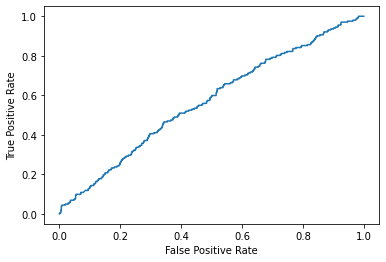

In [11]:
y_pred_proba = optimal_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot:>

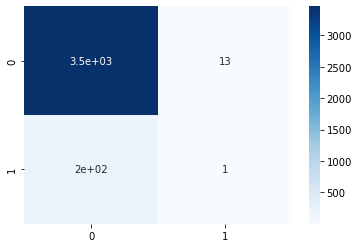

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = optimal_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues")

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3473
           1       0.07      0.00      0.01       202

    accuracy                           0.94      3675
   macro avg       0.51      0.50      0.49      3675
weighted avg       0.90      0.94      0.92      3675



### ROC AUC results are close to random classification

### Presicion and recall for '1' class are very low. We can see a high rate of FN and TP is nearly zero. This is not really surprising assuming strong class inbalance and several simplifications that were made during data processing and feature generation.

### High accuracy score in this case is not a valid metric for the model performance

In [14]:
rfc=RandomForestClassifier(random_state=42, class_weight='balanced', criterion='entropy', max_features = 'auto')
param_grid = { 
    'n_estimators': [200, 300, 500, 700],
    'max_depth' : [10, 15, 20, 25, 30, 40],
}

In [15]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=30, verbose=51)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

/home/aokhtienko/anaconda3/envs/brain_r/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              max_features='auto',
                                              random_state=42),
             n_jobs=30,
             param_grid={'max_depth': [10, 15, 20, 25, 30, 40],
                         'n_estimators': [200, 300, 500, 700]},
             verbose=51)

In [16]:
optimal_model = CV_rfc.best_estimator_
optimal_model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features='auto', n_estimators=500,
                       random_state=42)

In [17]:
metrics.roc_auc_score(y_test, optimal_model.predict_proba(X_test)[:,1])

0.5855139933803342

<AxesSubplot:>

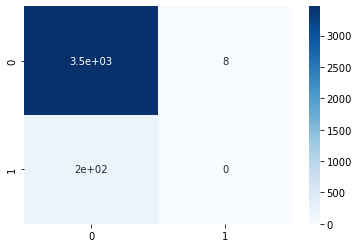

In [19]:
predictions = optimal_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues")

In [20]:
print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3473
           1       0.00      0.00      0.00       202

    accuracy                           0.94      3675
   macro avg       0.47      0.50      0.49      3675
weighted avg       0.89      0.94      0.92      3675

[CV 4/5; 5/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 4/5; 5/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.840 total time=   1.7s
[CV 5/5; 9/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=200
[CV 5/5; 9/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200;, score=0.818 total time=   1.5s
[CV 3/5; 12/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=700
[CV 3/5; 12/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=700;, score=0.819 total time=   4.1s
[CV 1/5; 21/96] START criterion=gini, max_depth=7, max_feature

[CV 1/5; 2/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300
[CV 1/5; 2/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.863 total time=   1.7s
[CV 5/5; 7/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500
[CV 5/5; 7/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500;, score=0.841 total time=   3.5s
[CV 4/5; 15/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500
[CV 4/5; 15/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.939 total time=   3.8s
[CV 5/5; 22/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=300
[CV 5/5; 22/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=300;, score=0.918 total time=   1.7s
[CV 5/5; 26/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300
[CV 5/5; 26/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.93

[CV 4/5; 1/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=200
[CV 4/5; 1/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.840 total time=   1.1s
[CV 2/5; 7/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500
[CV 2/5; 7/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500;, score=0.850 total time=   3.4s
[CV 2/5; 14/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=300
[CV 2/5; 14/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.925 total time=   2.2s
[CV 3/5; 18/96] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300
[CV 3/5; 18/96] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300;, score=0.931 total time=   2.2s
[CV 4/5; 22/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=300
[CV 4/5; 22/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=300;, score=0.93

[CV 1/5; 3/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500
[CV 1/5; 3/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.868 total time=   2.8s
[CV 3/5; 10/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=300
[CV 3/5; 10/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=300;, score=0.817 total time=   2.0s
[CV 1/5; 15/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500
[CV 1/5; 15/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.932 total time=   5.2s
[CV 4/5; 24/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=700
[CV 4/5; 24/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=700;, score=0.939 total time=   5.7s
[CV 5/5; 34/96] START criterion=gini, max_depth=8, max_features=log2, n_estimators=300
[CV 5/5; 34/96] END criterion=gini, max_depth=8, max_features=log2, n_estimators=300;, score=0.

[CV 1/5; 1/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=200
[CV 1/5; 1/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.860 total time=   1.5s
[CV 2/5; 8/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700
[CV 2/5; 8/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700;, score=0.848 total time=   4.0s
[CV 2/5; 17/96] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200
[CV 2/5; 17/96] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.925 total time=   2.1s
[CV 2/5; 21/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=200
[CV 2/5; 21/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=200;, score=0.920 total time=   1.7s
[CV 2/5; 23/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=500
[CV 2/5; 23/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=0.92

[CV 5/5; 6/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 5/5; 6/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300;, score=0.834 total time=   2.5s
[CV 5/5; 11/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=500
[CV 5/5; 11/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=0.832 total time=   2.4s
[CV 4/5; 16/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=700
[CV 4/5; 16/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=700;, score=0.940 total time=   4.9s
[CV 5/5; 25/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 5/5; 25/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.937 total time=   1.5s
[CV 5/5; 28/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=700
[CV 5/5; 28/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=700;, score=0.

[CV 2/5; 2/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300
[CV 2/5; 2/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.849 total time=   1.7s
[CV 1/5; 8/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700
[CV 1/5; 8/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700;, score=0.869 total time=   5.2s
[CV 4/5; 19/96] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500
[CV 4/5; 19/96] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500;, score=0.939 total time=   3.6s
[CV 4/5; 25/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 4/5; 25/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.944 total time=   2.4s
[CV 1/5; 30/96] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300
[CV 1/5; 30/96] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300;, score=0.93

[CV 1/5; 5/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 1/5; 5/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.860 total time=   1.6s
[CV 2/5; 9/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=200
[CV 2/5; 9/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200;, score=0.842 total time=   1.0s
[CV 2/5; 11/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=500
[CV 2/5; 11/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=0.836 total time=   2.5s
[CV 1/5; 16/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=700
[CV 1/5; 16/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=700;, score=0.932 total time=   5.2s
[CV 4/5; 26/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300
[CV 4/5; 26/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.94

[CV 1/5; 6/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 1/5; 6/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300;, score=0.863 total time=   1.7s
[CV 4/5; 9/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=200
[CV 4/5; 9/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=200;, score=0.828 total time=   1.0s
[CV 3/5; 11/96] START criterion=gini, max_depth=5, max_features=log2, n_estimators=500
[CV 3/5; 11/96] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=0.815 total time=   2.5s
[CV 3/5; 16/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=700
[CV 3/5; 16/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=700;, score=0.932 total time=   5.0s
[CV 3/5; 25/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 3/5; 25/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.94

[CV 5/5; 4/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=700
[CV 5/5; 4/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=700;, score=0.837 total time=   4.7s
[CV 2/5; 15/96] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500
[CV 2/5; 15/96] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.929 total time=   3.6s
[CV 2/5; 22/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=300
[CV 2/5; 22/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=300;, score=0.923 total time=   1.8s
[CV 5/5; 24/96] START criterion=gini, max_depth=7, max_features=log2, n_estimators=700
[CV 5/5; 24/96] END criterion=gini, max_depth=7, max_features=log2, n_estimators=700;, score=0.924 total time=   4.1s
[CV 2/5; 32/96] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=700
[CV 2/5; 32/96] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=700;, score=0.

[CV 2/5; 1/96] START criterion=gini, max_depth=5, max_features=auto, n_estimators=200
[CV 2/5; 1/96] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.844 total time=   1.5s
[CV 5/5; 8/96] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700
[CV 5/5; 8/96] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=700;, score=0.837 total time=   3.9s
[CV 3/5; 17/96] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200
[CV 3/5; 17/96] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.928 total time=   1.4s
[CV 1/5; 20/96] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=700
[CV 1/5; 20/96] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=700;, score=0.932 total time=   4.9s
[CV 2/5; 28/96] START criterion=gini, max_depth=8, max_features=auto, n_estimators=700
[CV 2/5; 28/96] END criterion=gini, max_depth=8, max_features=auto, n_estimators=700;, score=0.93

### in case we increase the max_depth, TP becomes 0